In [459]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

### Setting Up Primitives and Functions for Demonstrating Convex Hull algorithms

Generating X and Y Coordinates

In [460]:
num_points = 15

rng = np.random.default_rng()

x = rng.integers(0, 50, size=num_points)
y = rng.integers(0, 50, size=num_points)

x,y

(array([23, 42, 22,  6, 30, 45,  0, 14,  8,  4, 49, 34, 10, 37,  4]),
 array([23, 25, 20, 30, 22, 30,  3, 20,  2, 30, 17, 46, 44,  6, 46]))

In [461]:
points = np.column_stack((x, y))
# points = np.sort(points, axis=0)
points

array([[23, 23],
       [42, 25],
       [22, 20],
       [ 6, 30],
       [30, 22],
       [45, 30],
       [ 0,  3],
       [14, 20],
       [ 8,  2],
       [ 4, 30],
       [49, 17],
       [34, 46],
       [10, 44],
       [37,  6],
       [ 4, 46]])

<Axes: >

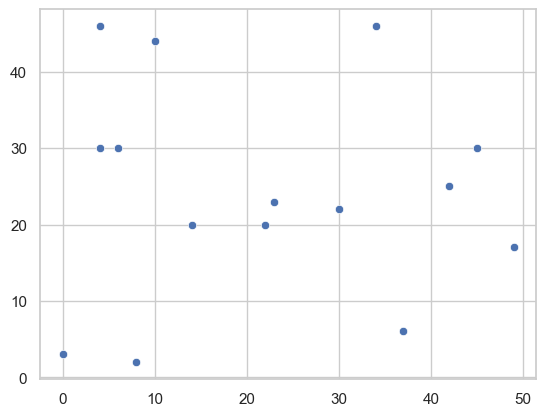

In [462]:
sns.scatterplot(x=x, y=y)

Defining a get_orientation function

In [463]:
def get_orientation(p1, p2, p3):
    '''
    Returns tuple (angle, direction)
    '''
    cross = np.cross(p2 - p1, p3 - p1)
    angle = np.arcsin(cross / (np.linalg.norm(p2-p1) * np.linalg.norm(p3 - p1)))
    if np.isclose(cross, 0):
        return (angle, 'collinear')      # Collinear
    return (angle, 'ccw') if cross > 0 else (angle, 'cw')

Defining an angle function

In [464]:
def angle(u,v):
    a = np.arccos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)))
    
    if np.isclose(a, 0):
        return 0
    else:
        return a

In [465]:
points[0][0], points[0][1]

(np.int64(23), np.int64(23))

Demonstration of functioning get_orientation method

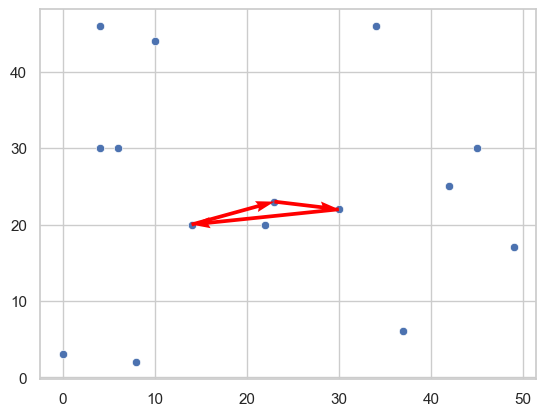

In [466]:
sns.scatterplot(x=x, y=y)

hull_points = [0,4,7]
x = points[hull_points, 0]
y = points[hull_points, 1]

# Calculate vectors (u, v) pointing to the next point
# np.roll shifts the array so we subtract point[i] from point[i+1]
u = np.roll(x, -1) - x
v = np.roll(y, -1) - y

# angles='xy', scale_units='xy', and scale=1 make the arrows 
# exactly as long as the distance between points
plt.quiver(x, y, u, v, color='red', angles='xy', scale_units='xy', scale=1)

In [467]:
val = get_orientation(points[0], points[4], points[7])
val

C:\Users\bisho\AppData\Local\Temp\ipykernel_7936\3243145145.py:5: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(p2 - p1, p3 - p1)


(np.float64(-0.46364760900080604), 'cw')

# Algorithm 1: Slow, Naive

In [468]:
hull_vectors = []

available_points = points.copy()

for i, p in enumerate(available_points):

    for j, q in enumerate(available_points):
        
        if i == j:
            continue

        valid = True

        for k, r in enumerate(available_points):
            
            if k == i or k == j:
                continue
            
            if get_orientation(p, q, r)[1] == 'ccw':
                valid = False
                break
    
            
        if valid:
            print(f"Appending p: {p}, q: {q}")
            hull_vectors.append([p, q])
            

hull_vectors = np.array(hull_vectors)

Appending p: [45 30], q: [49 17]
Appending p: [0 3], q: [ 4 46]
Appending p: [8 2], q: [0 3]
Appending p: [49 17], q: [37  6]
Appending p: [34 46], q: [45 30]
Appending p: [37  6], q: [8 2]
Appending p: [ 4 46], q: [34 46]


C:\Users\bisho\AppData\Local\Temp\ipykernel_7936\3243145145.py:5: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(p2 - p1, p3 - p1)


<Axes: >

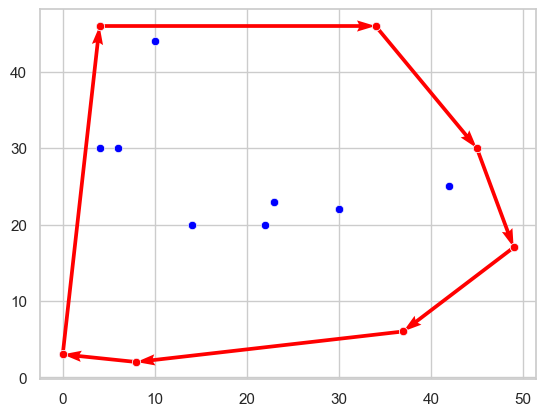

In [469]:
hull_points = np.unique(hull_vectors.reshape(len(hull_vectors) *2,2), axis = 0)

sns.scatterplot(x=x, y=y)

starts = hull_vectors[:, 0]
ends   = hull_vectors[:, 1]

x = starts[:, 0]
y = starts[:, 1]
u = ends[:, 0] - x
v = ends[:, 1] - y


plt.quiver(x, y, u, v, color='red', angles='xy', scale_units='xy', scale=1)
sns.scatterplot(x = points[:, 0], y = points[:,1], color = 'blue')
sns.scatterplot(x = hull_points[:, 0], y = hull_points[:, 1], color = 'red')

This was relatively easy to implement, but the $ O(n^3)$ run-time makes it much slower than other known algorithms. There is a lot of time wasted in the triple loop and this would not scale for larger datasets.

# Algorithm 2: Jarvis March or Gift Wrapping Algorithm

In [470]:

hull_vectors = []

leftmost = np.argmin(points[:, 0])
start = points[leftmost]

current = start
prev_dir = [0, 1]

while True:
    best_angle = -np.inf

    next_point = None

    for p in points:

        if np.array_equal(p, current):
            continue

        v = p - current
        a = angle(prev_dir, v)

        if a > best_angle:
            best_angle = a
            next_point = p

    hull_vectors.append([current, next_point])

    print(f'Prev: {current - prev_dir}, Current: {current}, Next: {next_point}')
    prev_dir = current - next_point

    current = next_point

    if np.array_equal(current, start):
        break
    
hull_vectors = np.array(hull_vectors)
hull_vectors

Prev: [0 2], Current: [0 3], Next: [8 2]
Prev: [16  1], Current: [8 2], Next: [37  6]
Prev: [66 10], Current: [37  6], Next: [49 17]
Prev: [61 28], Current: [49 17], Next: [45 30]
Prev: [41 43], Current: [45 30], Next: [34 46]
Prev: [23 62], Current: [34 46], Next: [ 4 46]
Prev: [-26  46], Current: [ 4 46], Next: [0 3]


C:\Users\bisho\AppData\Local\Temp\ipykernel_7936\787920581.py:2: RuntimeWarning: invalid value encountered in arccos
  a = np.arccos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)))


array([[[ 0,  3],
        [ 8,  2]],

       [[ 8,  2],
        [37,  6]],

       [[37,  6],
        [49, 17]],

       [[49, 17],
        [45, 30]],

       [[45, 30],
        [34, 46]],

       [[34, 46],
        [ 4, 46]],

       [[ 4, 46],
        [ 0,  3]]])

<Axes: >

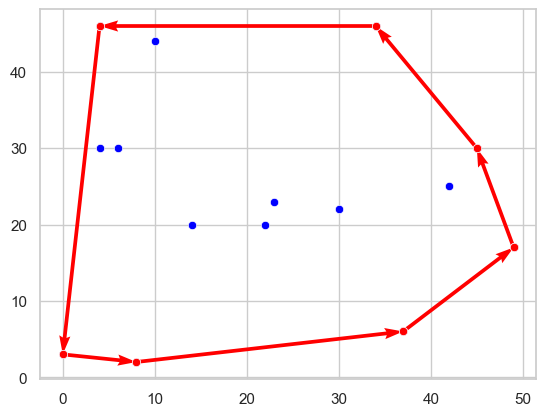

In [471]:
hull_points = np.unique(hull_vectors.reshape(len(hull_vectors) *2,2), axis = 0)

sns.scatterplot(x=x, y=y)

starts = hull_vectors[:, 0]
ends   = hull_vectors[:, 1]

x = starts[:, 0]
y = starts[:, 1]
u = ends[:, 0] - x
v = ends[:, 1] - y


plt.quiver(x, y, u, v, color='red', angles='xy', scale_units='xy', scale=1)
sns.scatterplot(x = points[:, 0], y = points[:,1], color = 'blue')
sns.scatterplot(x = hull_points[:, 0], y = hull_points[:, 1], color = 'red')

Gift-wrapping is very easily to understand intuitively, making it much easier to implement. It is not much more difficult to program than the naive method and is output-sensitive at $O(nh)$ where $h$ is the number of points that lie on the convex hull. It is not the fastest possible algorithm, like Chan's, but it is still fast in cases where $h$ is low.

# Algorithm 3: Monotone Chain Algorithm

In [472]:
sorted_indices = np.argsort(points[:, 0])
sorted_points = points[sorted_indices]
sorted_points

array([[ 0,  3],
       [ 4, 30],
       [ 4, 46],
       [ 6, 30],
       [ 8,  2],
       [10, 44],
       [14, 20],
       [22, 20],
       [23, 23],
       [30, 22],
       [34, 46],
       [37,  6],
       [42, 25],
       [45, 30],
       [49, 17]])

In [473]:
upper = [sorted_points[0], sorted_points[1]]

for i in range(2, len(sorted_points)):

    p_i = sorted_points[i]
    upper.append(p_i)

    while len(upper) > 2 and get_orientation(upper[-3], upper[-2], upper[-1])[1] != 'cw':
        upper.pop(-2)

lower = [sorted_points[-1], sorted_points[-2]]

for i in range(len(sorted_points)-2, -1, -1):

    p_i = sorted_points[i]
    lower.append(p_i)

    while len(lower) > 2 and get_orientation(lower[-3], lower[-2], lower[-1])[1] != 'cw':
        lower.pop(-2)

hull_points = np.concat([upper, lower])
hull_points

C:\Users\bisho\AppData\Local\Temp\ipykernel_7936\3243145145.py:5: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(p2 - p1, p3 - p1)


array([[ 0,  3],
       [ 4, 46],
       [34, 46],
       [45, 30],
       [49, 17],
       [49, 17],
       [37,  6],
       [ 8,  2],
       [ 0,  3]])

In [474]:
vectors = np.roll(hull_points, -1, axis = 0) - hull_points
vectors

array([[  4,  43],
       [ 30,   0],
       [ 11, -16],
       [  4, -13],
       [  0,   0],
       [-12, -11],
       [-29,  -4],
       [ -8,   1],
       [  0,   0]])

<Axes: >

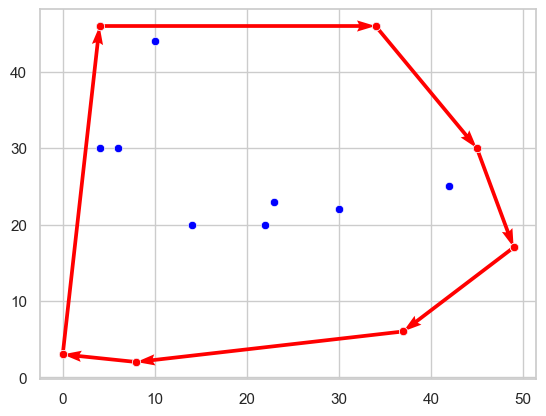

In [475]:
sns.scatterplot(x=x, y=y)

x = hull_points[:, 0]
y = hull_points[:, 1]
u = vectors[:, 0]
v = vectors[:, 1]


plt.quiver(x, y, u, v, color='red', angles='xy', scale_units='xy', scale=1)
sns.scatterplot(x = points[:, 0], y = points[:,1], color = 'blue')
sns.scatterplot(x = hull_points[:, 0], y = hull_points[:, 1], color = 'red')

This was likely the easiest to program, although not as easy to understand conceptually, due to the dropping of indices in the center of the array. It was not intuitively challenging, but making sure I understood the process in which points could be dropped was important. There was an edge case where the boundaries of the lower bound were not considering the leftmost point initially in my implementation, making it more challenging to debug.

Overall, the algorithm runs very quickly, at $O(n\log(n))$ making the algorithm hit the lower bound of convex hull efficiency in the worst-case scenario (although not as quick as Chan's Algorithm).